In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import pickle, os
from datetime import datetime
import numpy as np


In [2]:
# === Creazione cartella esperimento con timestamp ISO ===
timestamp = datetime.now().strftime("%H-%M-%S")
print(f"Ora inizio esperimento: {timestamp}")
day= datetime.now().strftime("%Y-%m-%d")
print(f"Giorno inizio esperimento: {day}")
exp_dir = f"../RISULTATI/{day}/esperimento_Global_Arpat_{timestamp}"

os.makedirs(exp_dir, exist_ok=True)

print(f"Cartella esperimento creata: {exp_dir}")

Ora inizio esperimento: 14-36-49
Giorno inizio esperimento: 2025-11-30
Cartella esperimento creata: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49


In [3]:
def save_pkl(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"Salvato: {path}")

def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [4]:
import os
import numpy as np

def load_and_merge_tensors(file_list, path):
    """
    Carica i file .pkl da `path` + nome in file_list, concatena globalmente
    X_train, X_test, y_train, y_test e costruisce un dizionario:
      sensor_splits = { 'SENSORE': (X_test_concat_or_None, y_test_concat_or_None), ... }

    Richiede una funzione `load_pkl(full_path)` definita altrove che ritorna un np.ndarray.
    """
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    # temporanei per i test per sensore
    sensors = {}  # sensor -> {"X_test": [...], "y_test": [...]}

    for f in file_list:
        full = os.path.join(path, f)
        arr = load_pkl(full)  # deve restituire np.ndarray

        # estrai nome sensore dopo "unscaled_"
        base = os.path.basename(f)
        sensor = None
        if "unscaled_" in base:
            sensor = base.split("unscaled_")[1].replace(".pkl", "")

        if base.startswith("X_train_unscaled"):
            X_train_list.append(arr)

        elif base.startswith("X_test_unscaled"):
            X_test_list.append(arr)
            if sensor is not None:
                sensors.setdefault(sensor, {"X_test": [], "y_test": []})["X_test"].append(arr)

        elif base.startswith("y_train_unscaled"):
            y_train_list.append(arr)

        elif base.startswith("y_test_unscaled"):
            y_test_list.append(arr)
            if sensor is not None:
                sensors.setdefault(sensor, {"X_test": [], "y_test": []})["y_test"].append(arr)

    # concatenazioni globali
    X_train = np.concatenate(X_train_list, axis=0) if X_train_list else None
    X_test = np.concatenate(X_test_list, axis=0) if X_test_list else None
    y_train = np.concatenate(y_train_list, axis=0) if y_train_list else None
    y_test = np.concatenate(y_test_list, axis=0) if y_test_list else None

    # costruisci dizionario richiesta: sensor -> (X_test, y_test)
    sensor_splits = {}
    for sensor, d in sensors.items():
        Xs = np.concatenate(d["X_test"], axis=0) if d.get("X_test") else None
        ys = np.concatenate(d["y_test"], axis=0) if d.get("y_test") else None
        sensor_splits[sensor] = (Xs, ys)

    return X_train, X_test, y_train, y_test, sensor_splits


In [5]:
path = '/Users/lapotinacci/thesis/Federated_Sys/train_test'
files = os.listdir(path)
files.sort()
files = [f for f in files if 'METRO' not in f.upper()]
print(files)
len(files)

['X_test_unscaled_AR-ACROPOLI.pkl', 'X_test_unscaled_FI-GRAMSCI.pkl', 'X_test_unscaled_FI-SETTIGNANO.pkl', 'X_test_unscaled_GR-MAREMMA.pkl', 'X_test_unscaled_LI-LAPIRA.pkl', 'X_test_unscaled_LU-VIAREGGIO.pkl', 'X_test_unscaled_PO-ROMA.pkl', 'X_train_unscaled_AR-ACROPOLI.pkl', 'X_train_unscaled_FI-GRAMSCI.pkl', 'X_train_unscaled_FI-SETTIGNANO.pkl', 'X_train_unscaled_GR-MAREMMA.pkl', 'X_train_unscaled_LI-LAPIRA.pkl', 'X_train_unscaled_LU-VIAREGGIO.pkl', 'X_train_unscaled_PO-ROMA.pkl', 'y_test_unscaled_AR-ACROPOLI.pkl', 'y_test_unscaled_FI-GRAMSCI.pkl', 'y_test_unscaled_FI-SETTIGNANO.pkl', 'y_test_unscaled_GR-MAREMMA.pkl', 'y_test_unscaled_LI-LAPIRA.pkl', 'y_test_unscaled_LU-VIAREGGIO.pkl', 'y_test_unscaled_PO-ROMA.pkl', 'y_train_unscaled_AR-ACROPOLI.pkl', 'y_train_unscaled_FI-GRAMSCI.pkl', 'y_train_unscaled_FI-SETTIGNANO.pkl', 'y_train_unscaled_GR-MAREMMA.pkl', 'y_train_unscaled_LI-LAPIRA.pkl', 'y_train_unscaled_LU-VIAREGGIO.pkl', 'y_train_unscaled_PO-ROMA.pkl']


28

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Primo split: train (80%) vs temp (20%)
# Passo anche std_bins per poter stratificare
X_train, X_test, y_train, y_test, splits = load_and_merge_tensors(files, path)

print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")

# Debug prints
print(f"Final shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Scaler per input
scaler_X = StandardScaler()
X_train_n = scaler_X.fit_transform(X_train)
X_val   = scaler_X.transform(X_val)
X_test  = scaler_X.transform(X_test)

# Scaler per output (se serve normalizzare anche y)
scaler_y = StandardScaler()
y_train_n = scaler_y.fit_transform(y_train)
y_val   = scaler_y.transform(y_val)
y_test  = scaler_y.transform(y_test)

#  === Salvataggio dataset e scaler in formato .pkl ===
save_pkl(X_train_n, os.path.join(exp_dir, "X_train.pkl"))
save_pkl(y_train_n, os.path.join(exp_dir, "y_train.pkl"))
save_pkl(X_val, os.path.join(exp_dir, "X_val.pkl"))
save_pkl(y_val, os.path.join(exp_dir, "y_val.pkl"))
save_pkl(X_test, os.path.join(exp_dir, "X_test.pkl"))
save_pkl(y_test, os.path.join(exp_dir, "y_test.pkl"))

save_pkl(scaler_X, os.path.join(exp_dir, "scaler_X.pkl"))
save_pkl(scaler_y, os.path.join(exp_dir, "scaler_y.pkl"))

print("Scaler salvati.")

print("\nTutti i file sono stati salvati correttamente.")
print(f"Percorso cartella: {os.path.abspath(exp_dir)}")

Train size: (1795, 33), (1795, 24)
Test size: (453, 33), (453, 24)
Final shapes:
X_train: (1795, 33)
y_train: (1795, 24)
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/X_train.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/y_train.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/X_val.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/y_val.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/X_test.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/y_test.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/scaler_X.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/scaler_y.pkl
Scaler salvati.

Tutti i file sono stati salvati correttamente.
Percorso cartella: /Users/lapotinacci/thesis/Federated_Sys/RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [8]:
def save_prediction_plots(y_true, y_pred, output_dir, prefix="pred_plot"):
    os.makedirs(output_dir, exist_ok=True)

    n = len(y_true)
    print(f"Salvo {n} plot in: {output_dir}")

    for i in range(n):
        plt.figure(figsize=(8, 3))
        plt.plot(y_true[i], label="True")
        plt.plot(y_pred[i], label="Pred")
        plt.legend()
        plt.tight_layout()

        filename = f"{prefix}_{i+1}.png"
        path = os.path.join(output_dir, filename)

        plt.savefig(path)
        plt.close()

    print("Plot salvati correttamente.")


In [9]:
# Definizione modello DNN
def build_model(input_shape: tuple, output_shape: tuple):
    model = models.Sequential([
        layers.Dense(128, activation = "relu", input_shape=input_shape),
        Dropout(0.3),
        layers.Dense(output_shape, 'linear')
    ])
    model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.016, weight_decay=0.0206),
    loss= 'mse',
    metrics=['mae'],
    )
    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # metrica da monitorare, es. val_loss o val_mae
    patience=50,             # numero di epoche senza miglioramento prima di fermare
    restore_best_weights=True,  # ripristina i pesi migliori trovati
    verbose = 1
)

# Training del modello
model = build_model((X_test.shape[1],), y_test.shape[1])
history = model.fit(
    X_train_n, y_train_n,
    epochs=1000,
    batch_size=256,
    callbacks = [early_stop],
    validation_data=(X_val, y_val),
    verbose=1
    )
y_pred = model.predict(X_test)

'''print("y_train min/max:", y_train_np.min(), y_train_np.max())
print("y_pred min/max (scaled):", y_pred.min(), y_pred.max())
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
print("y_pred_rescaled min/max:", y_pred_rescaled.min(), y_pred_rescaled.max())'''



Epoch 1/1000


/Users/lapotinacci/thesis/Federated_Sys/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6209 - mae: 0.5626 - val_loss: 0.1591 - val_mae: 0.2879
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2369 - mae: 0.3594 - val_loss: 0.1023 - val_mae: 0.2288
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1528 - mae: 0.2839 - val_loss: 0.0788 - val_mae: 0.1953
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1152 - mae: 0.2424 - val_loss: 0.0669 - val_mae: 0.1766
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0914 - mae: 0.2143 - val_loss: 0.0549 - val_mae: 0.1546
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0816 - mae: 0.1979 - val_loss: 0.0481 - val_mae: 0.1440
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0759 - mae: 0.1886 - val_loss: 0.0477 - val_mae: 0.1463
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0700 - mae: 0.1813 - val_loss: 0.0453 - val_mae: 0.1405
Epoch 9/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0694 - mae: 0.1797 - va

'print("y_train min/max:", y_train_np.min(), y_train_np.max())\nprint("y_pred min/max (scaled):", y_pred.min(), y_pred.max())\ny_pred_rescaled = scaler_y.inverse_transform(y_pred)\nprint("y_pred_rescaled min/max:", y_pred_rescaled.min(), y_pred_rescaled.max())'

In [10]:
model = tf.keras.models.load_model(f'{exp_dir}/model/NO2_global_model.keras') if os.path.exists(f'{exp_dir}/model/NO2_global_model.keras') else model

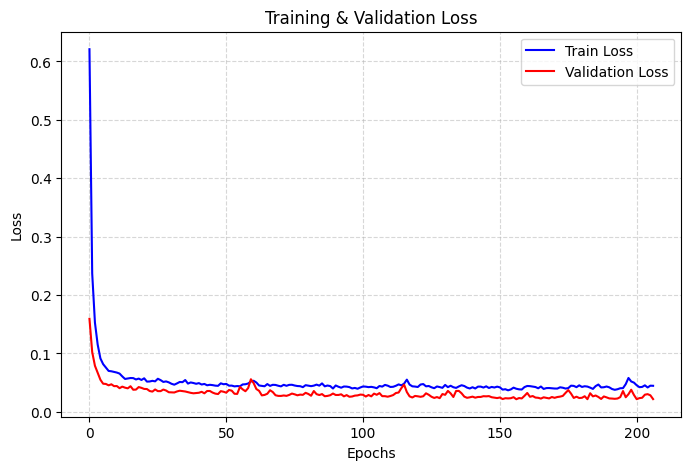

In [11]:
# Estrai losses da tutti i folds
train_losses = history.history['loss']
val_losses   = history.history['val_loss']

train_losses = train_losses
val_losses = val_losses

# Plot
plt.figure(figsize=(8,5))


# Training loss
plt.plot(train_losses, color='blue', label='Train Loss')
# Validation loss
plt.plot(val_losses, color='red', label='Validation Loss')


# Dettagli grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'{exp_dir}/loss_plot.png')



In [12]:
def plot_first_n_series(y_pred, y_test, n_series=10, title="Confronto Serie Predette vs Reali"):
    """
    Plotta le prime n_series serie reali e predette per un confronto diretto.

    Args:
        y_pred (np.ndarray): Predizioni del modello (shape: num_samples x seq_len).
        y_test (np.ndarray): Serie reali (shape: num_samples x seq_len).
        n_series (int): Numero di serie da plottare.
        title (str): Titolo del grafico.
    """

    # Limitiamo a n_series per evitare problemi
    n = min(n_series, y_pred.shape[0], y_test.shape[0])

    plt.figure(figsize=(14, 8))

    for i in range(n):
        plt.plot(
            y_test[i], 
            linewidth=1.8, 
            alpha=0.7, 
            label=f"Reale {i+1}" if i == 0 else "",
            color = 'blue'
        )
        plt.plot(
            y_pred[i], 
            linewidth=1.8, 
            linestyle="--", 
            alpha=0.9, 
            label=f"Predetto {i+1}" if i == 0 else "",
            color = 'red'
        )

    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Valore", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
import seaborn as sns

def plot_diagnosis_gradient(y_pred, y_test, save_path: str,  tolerance:float =0.05, max_samples_heatmap=50, scatter_sample_ratio=0.5, tol_auto = True):
    """
    Dashboard diagnostica con tolleranza AUTO-ADATTIVA alla scala dei dati.
    
    Args:
        tolerance (float): 
            - Se None: La tolleranza viene calcolata automaticamente come il 5% del range dei dati (Max-Min).
            - Se float: Valore assoluto (es. 0.5).
        tol_auto (bool): Se True, usa la tolleranza automatica basata sul range dei dati, altrimenti usa il valore manuale fornito 
        col parametro tolerance.
    """
    
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()

    # ---------------------------------------------------------
    # AUTOMAZIONE TOLLERANZA
    # ---------------------------------------------------------
    if tol_auto:
        data_range = y_test_flat.max() - y_test_flat.min()
        # Impostiamo la tolleranza al 5% del range totale (regolabile)
        tolerance = data_range * tolerance 
        tol_label = f"Auto (5% Range: ±{tolerance:.2f})"
    else:
        tol_label = f"Manuale (±{tolerance})"

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))

    # -----------------------------
    # 1. HEATMAP (SX)
    # -----------------------------
    errors = np.abs(y_test - y_pred)
    errors_subset = errors[:max_samples_heatmap]
    
    # Adattiamo anche la scala colori della heatmap alla tolleranza
    # Tutto ciò che è oltre 3 volte la tolleranza è "errore massimo" visivo
    sns.heatmap(errors_subset, cmap="plasma", ax=axes[0], 
                vmax=tolerance * 3,
                cbar_kws={'label': 'Errore Assoluto'})
    
    axes[0].set_title(f"Heatmap Errori (Primi {max_samples_heatmap} campioni)", fontsize=16)
    axes[0].set_xlabel("Time Step", fontsize=12)
    axes[0].set_ylabel("Indice Campione", fontsize=12)

    # -----------------------------
    # 2. SCATTER CON SFONDO GRADIENTE (DX)
    # -----------------------------
    
    # Campionamento dati
    if scatter_sample_ratio < 1.0:
        mask = np.random.rand(len(y_test_flat)) < scatter_sample_ratio
        sample_test = y_test_flat[mask]
        sample_pred = y_pred_flat[mask]
    else:
        sample_test = y_test_flat
        sample_pred = y_pred_flat

    # Calcolo limiti grafico
    min_val = min(y_test_flat.min(), y_pred_flat.min())
    max_val = max(y_test_flat.max(), y_pred_flat.max())
    padding = (max_val - min_val) * 0.05
    plot_min = min_val - padding
    plot_max = max_val + padding

    # --- SFONDO GRADIENTE ---
    grid_x, grid_y = np.meshgrid(
        np.linspace(plot_min, plot_max, 200),
        np.linspace(plot_min, plot_max, 200)
    )
    grid_z = np.abs(grid_y - grid_x)

    im = axes[1].imshow(
        grid_z, 
        extent=(plot_min, plot_max, plot_min, plot_max), 
        origin='lower', 
        cmap='RdYlGn_r', 
        alpha=0.4, 
        vmax=tolerance * 4, # Il rosso satura a 4x della tolleranza
        aspect='auto'
    )

    # --- PUNTI BLU ---
    axes[1].scatter(
        sample_test, 
        sample_pred, 
        alpha=0.6, 
        s=15, 
        color='royalblue', 
        edgecolors='white', 
        linewidth=0.3,
        label='Campioni'
    )

    axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')

    # Metriche
    within_tol = np.mean(np.abs(y_test_flat - y_pred_flat) <= tolerance) * 100

    axes[1].set_title(
        f"Bontà delle previsioni con {tol_label}\nValori nel range di Tolleranza: {within_tol:.1f}%", 
        fontsize=16
    )
    axes[1].set_xlabel("Valore Reale", fontsize=12)
    axes[1].set_ylabel("Valore Predetto", fontsize=12)
    axes[1].set_xlim(plot_min, plot_max)
    axes[1].set_ylim(plot_min, plot_max)
    
    cbar = plt.colorbar(im, ax=axes[1], pad=0.02)
    cbar.set_label('Gravità Errore (Distanza da diagonale)')

    plt.tight_layout()
    plt.savefig(f'{exp_dir}/{save_path}.png')

 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


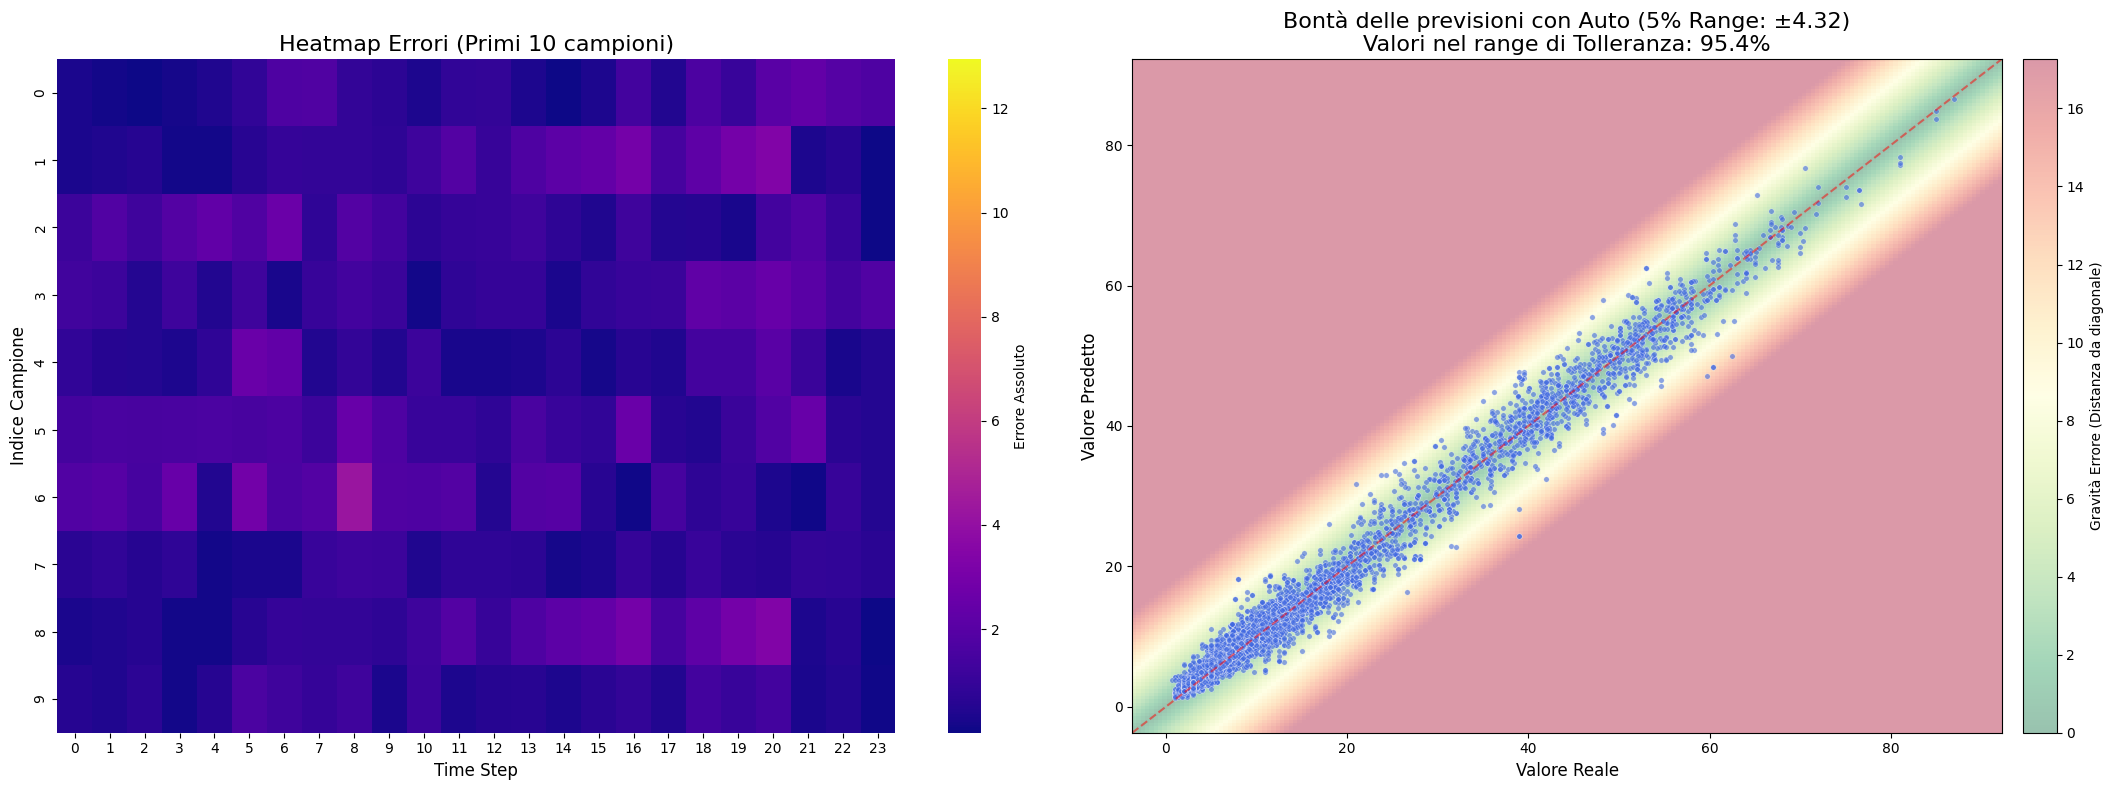

In [14]:
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test_np = scaler_y.inverse_transform(y_test)

plot_diagnosis_gradient(y_pred, y_test_np,save_path='pred_quality', max_samples_heatmap=10, scatter_sample_ratio=0.7)

In [15]:
import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_and_log(y_true, y_pred, log_path="log.json"):
    # --- Metriche ---
    mae = mean_absolute_error(y_true, y_pred, multioutput="uniform_average")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput="uniform_average"))

    mask = y_true != 0
    mape = float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0)

    r2 = r2_score(y_true, y_pred, multioutput="uniform_average")

    # Valore medio del test set
    v_mean = float(np.mean(y_true))

    # --- Stampa ---
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test R2: {r2:.4f}")
    print(f"Valore medio del test set: {v_mean:.4f}")

    # --- Salvataggio log ---
    log_data = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "test_mean_value": v_mean
    }

    with open(log_path, "w") as f:
        json.dump(log_data, f, indent=4)

    print(f"\nLog salvato in: {log_path}")
evaluate_and_log(y_test_np, y_pred, log_path=f"{exp_dir}/evaluation_log.json")
# Impostazioni pandas per visualizzare tutti i dati

Test MAE: 1.3767
Test RMSE: 1.9762
Test MAPE: 17.83%
Test R2: 0.9817
Valore medio del test set: 14.5727

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log.json


Sensore: AR-ACROPOLI, X_test shape: (55, 33), y_test shape: (55, 24)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Test MAE: 1.0263
Test RMSE: 1.2409
Test MAPE: 20.89%
Test R2: -0.5720
Valore medio del test set: 5.9393

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_AR-ACROPOLI.json
Salvo 55 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_AR-ACROPOLI
Plot salvati correttamente.
Sensore: FI-GRAMSCI, X_test shape: (92, 33), y_test shape: (92, 24)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Test MAE: 2.2119
Test RMSE: 2.9443
Test MAPE: 5.90%
Test R2: 0.8553
Valore medio del test set: 41.6166

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_FI-GRAMSCI.json
Salvo 92 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_FI-GRAMSCI
Plot salvati correttamente.
Sensore: FI-SETTIGNANO, X_test shape: (55, 33), y_test shape: (55, 24)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MAE: 0.7249
Test RMSE: 0.9372
Test MAPE: 32.22%
Test R2: -0.2023
Valore medio del test set: 2.8578

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_FI-SETTIGNANO.json
Salvo 55 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_FI-SETTIGNANO


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Plot salvati correttamente.
Sensore: GR-MAREMMA, X_test shape: (62, 33), y_test shape: (62, 24)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Test MAE: 0.7966
Test RMSE: 0.9186
Test MAPE: 27.99%
Test R2: -3.4547
Valore medio del test set: 3.0654

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_GR-MAREMMA.json
Salvo 62 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_GR-MAREMMA
Plot salvati correttamente.
Sensore: LI-LAPIRA, X_test shape: (55, 33), y_test shape: (55, 24)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MAE: 1.6266
Test RMSE: 2.3717
Test MAPE: 13.23%
Test R2: 0.7904
Valore medio del test set: 13.7463

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_LI-LAPIRA.json
Salvo 55 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_LI-LAPIRA


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Plot salvati correttamente.
Sensore: LU-VIAREGGIO, X_test shape: (74, 33), y_test shape: (74, 24)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Test MAE: 1.2752
Test RMSE: 1.7251
Test MAPE: 13.59%
Test R2: 0.4073
Valore medio del test set: 10.5587

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_LU-VIAREGGIO.json
Salvo 74 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_LU-VIAREGGIO
Plot salvati correttamente.
Sensore: PO-ROMA, X_test shape: (60, 33), y_test shape: (60, 24)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3237/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Test MAE: 1.5103
Test RMSE: 2.0685
Test MAPE: 19.10%
Test R2: 0.5390
Valore medio del test set: 9.3573

Log salvato in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/evaluation_log_sensor_PO-ROMA.json
Salvo 60 plot in: ../RISULTATI/2025-11-30/esperimento_Global_Arpat_14-36-49/TEST_sensor_PO-ROMA
Plot salvati correttamente.


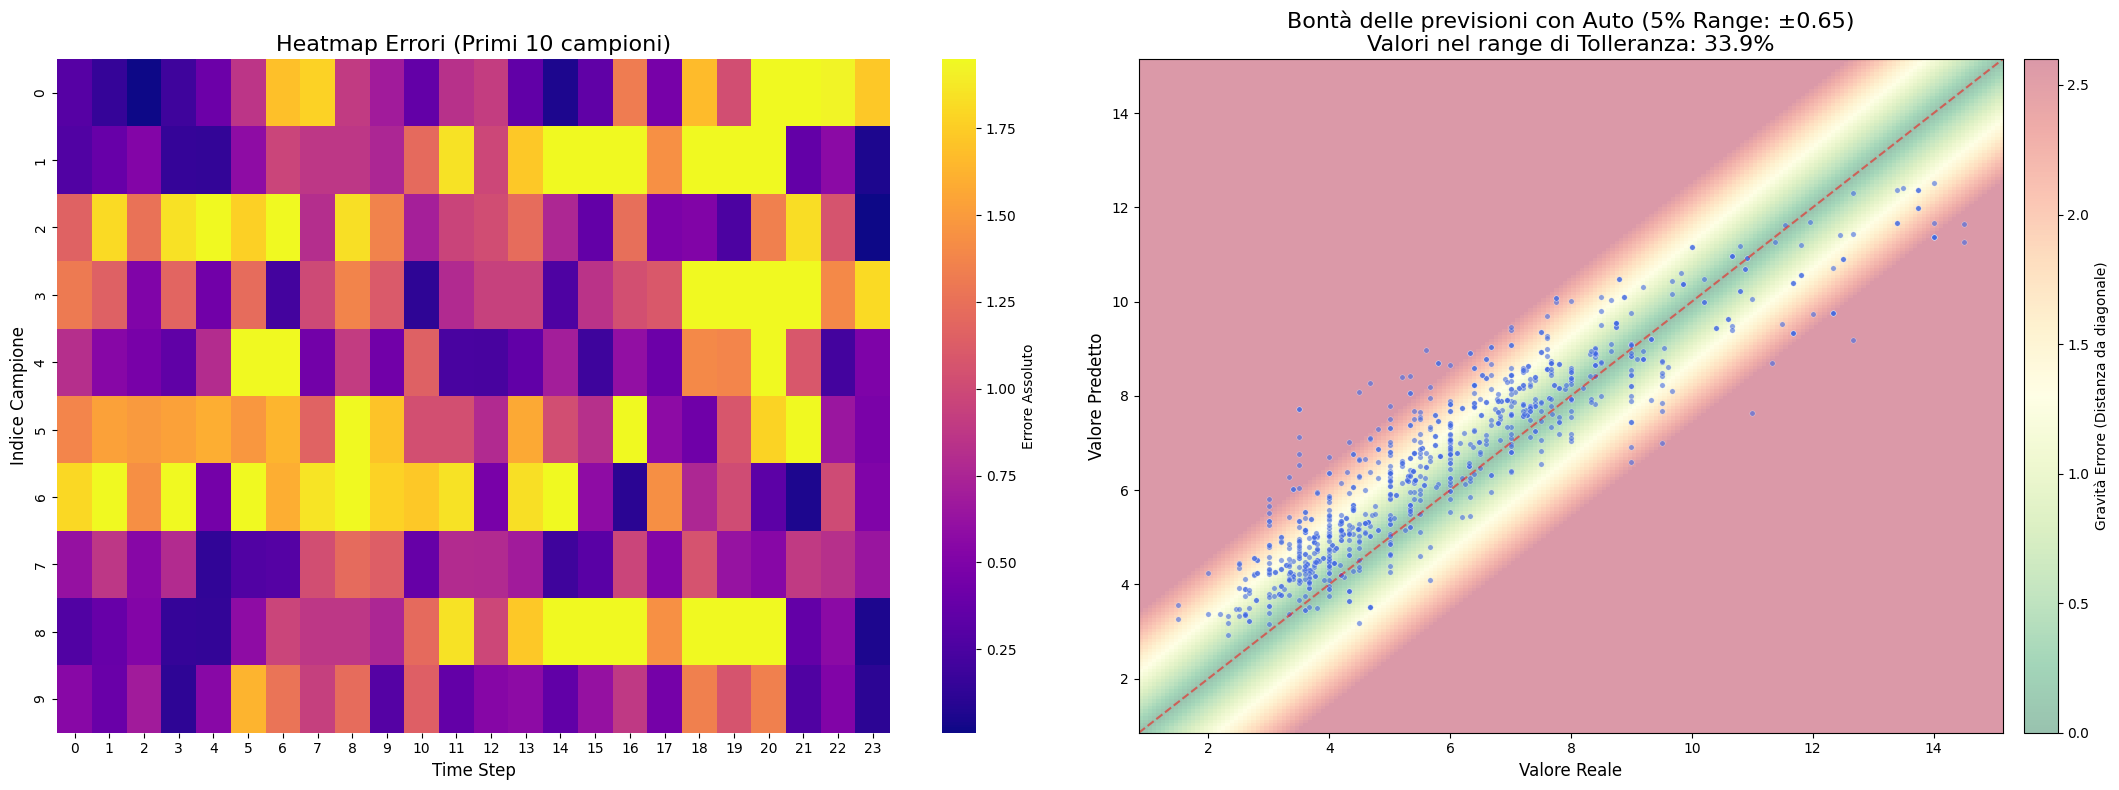

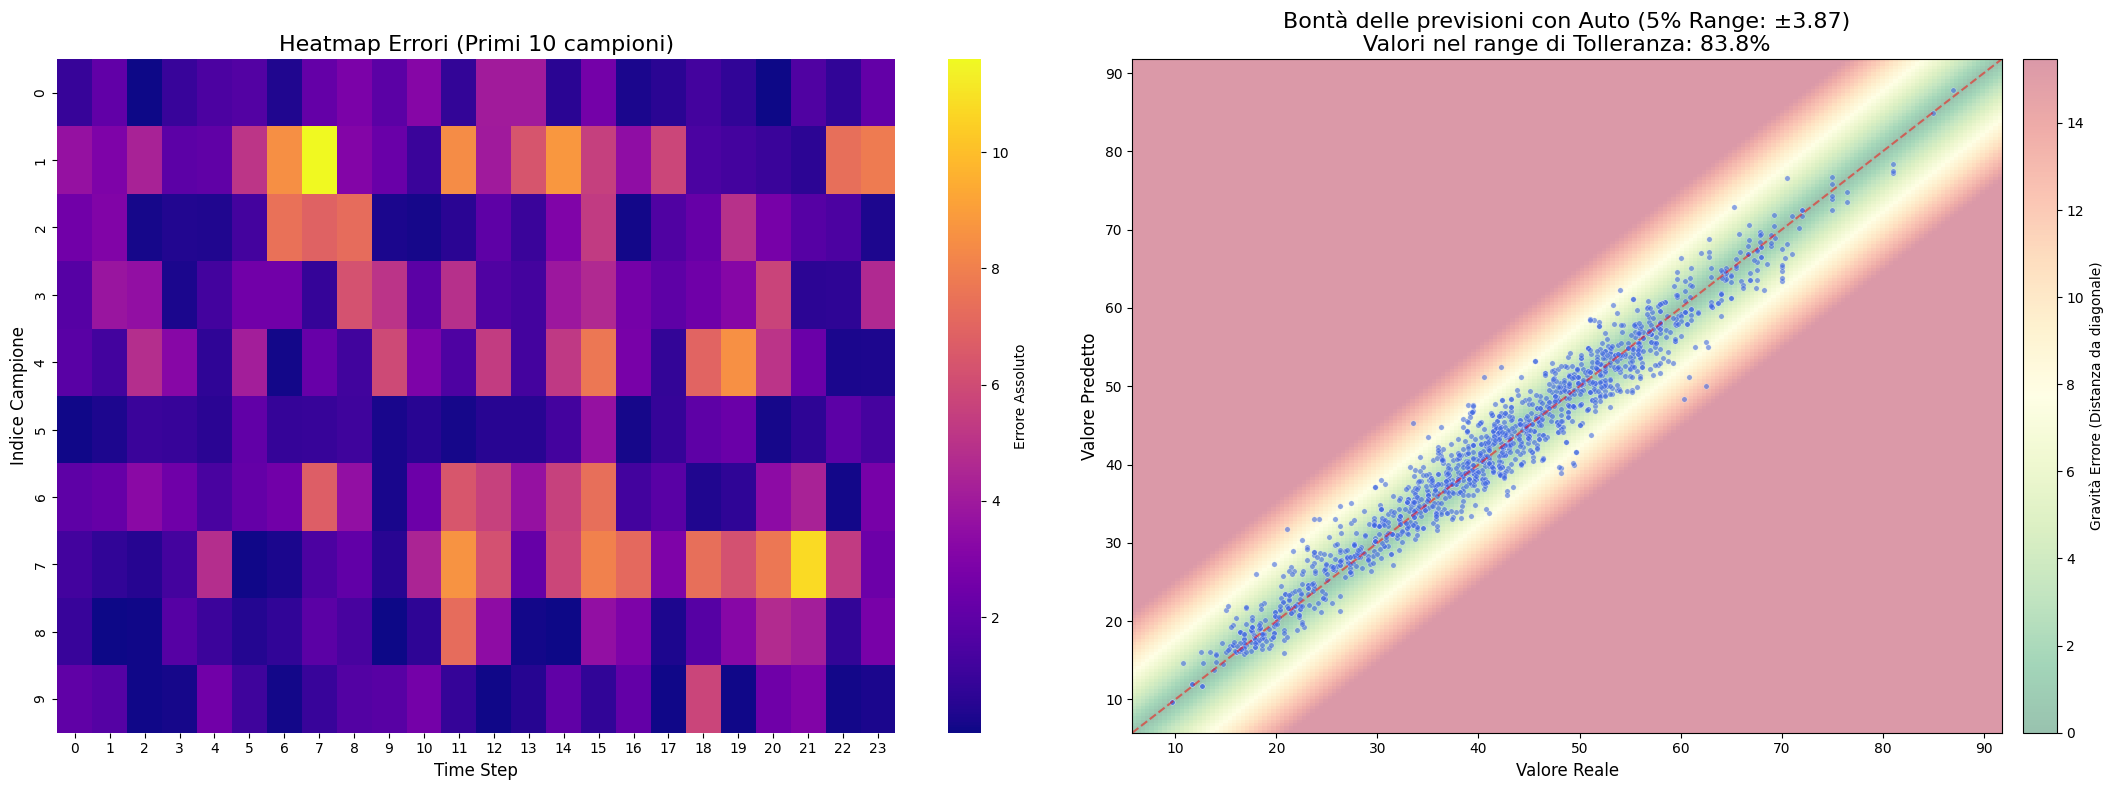

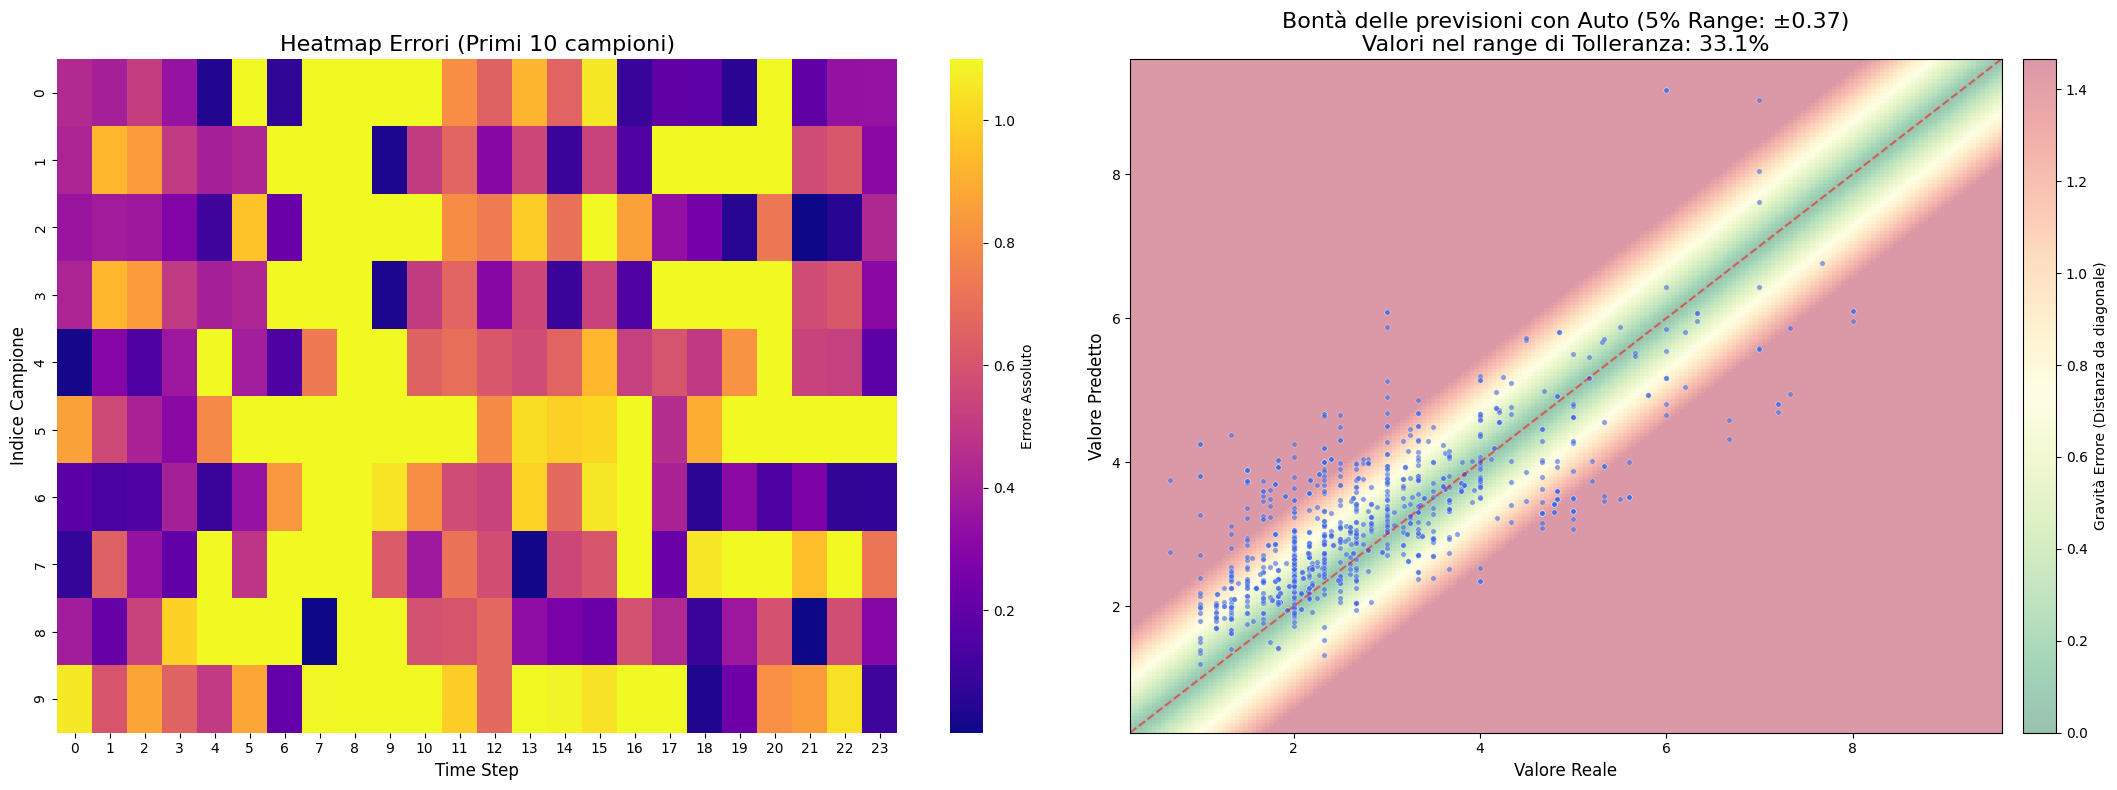

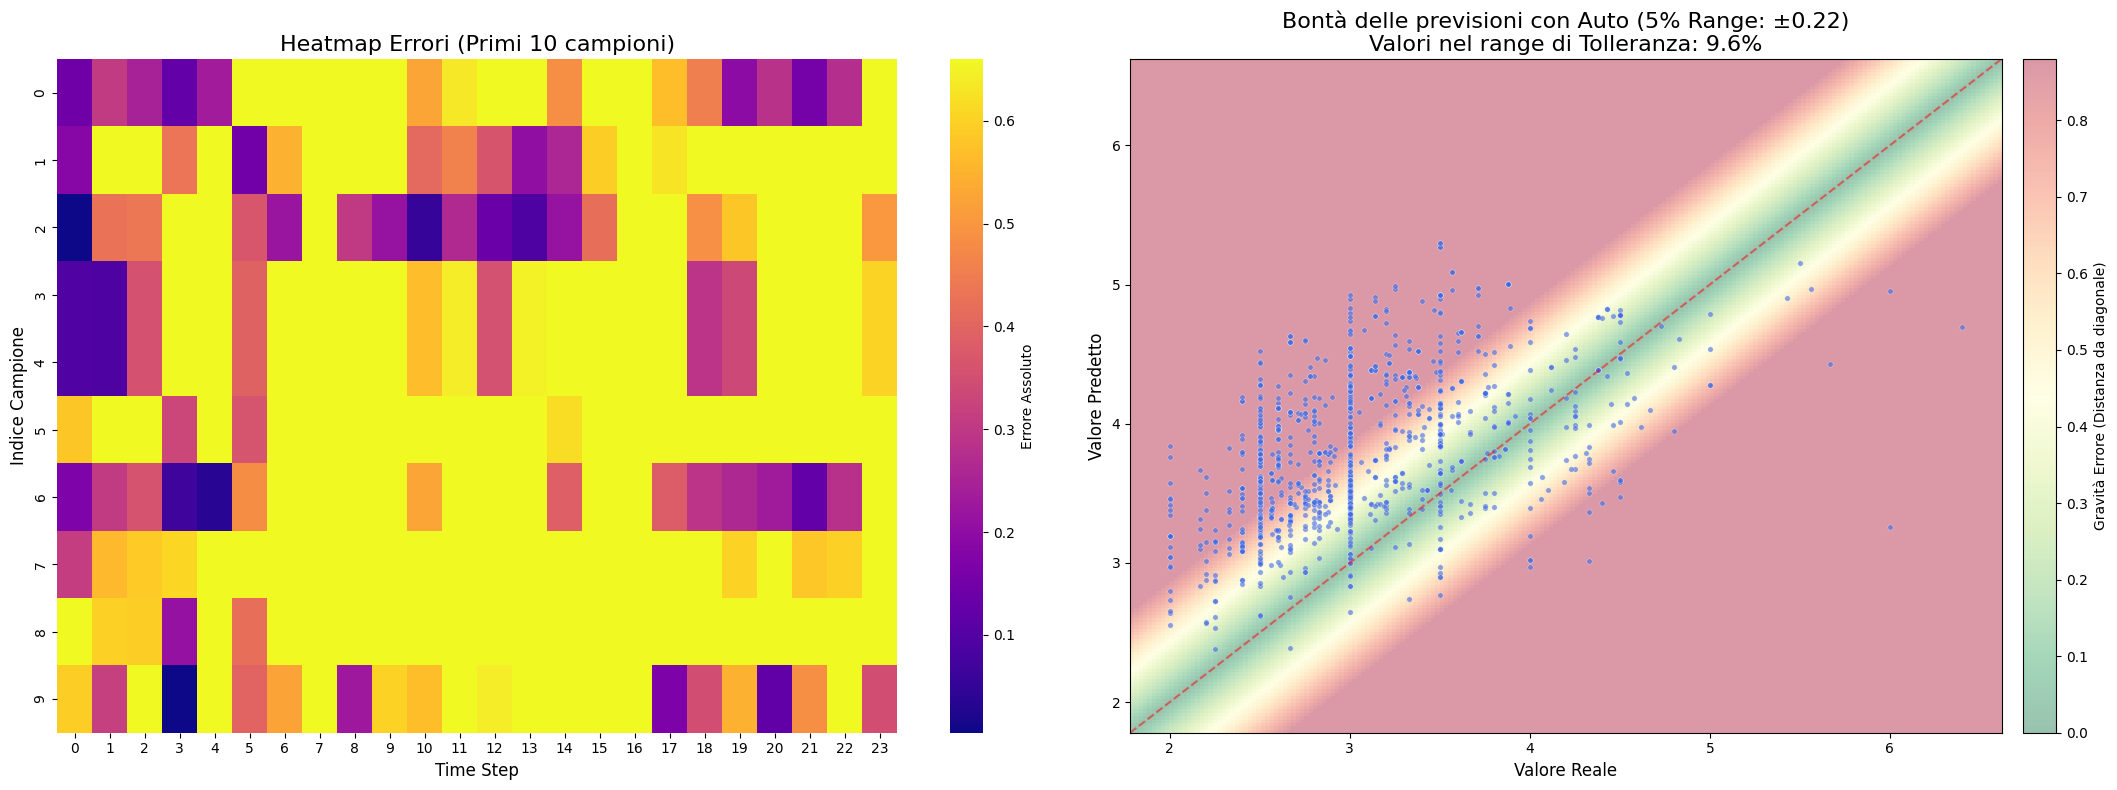

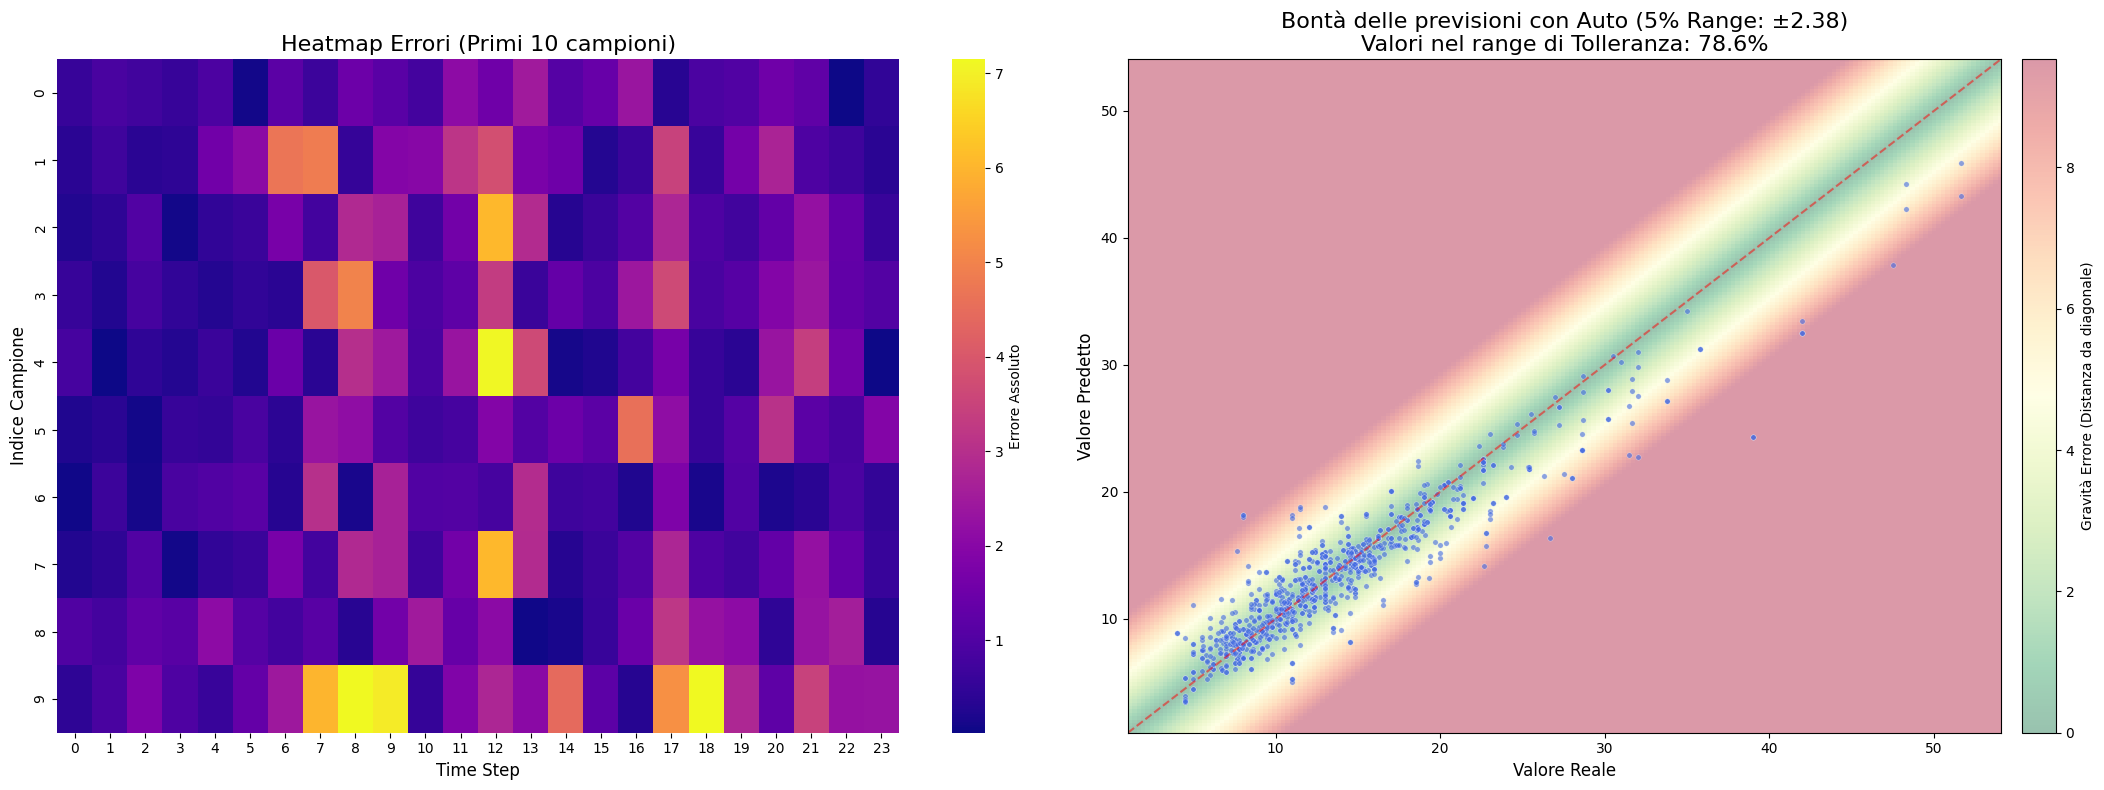

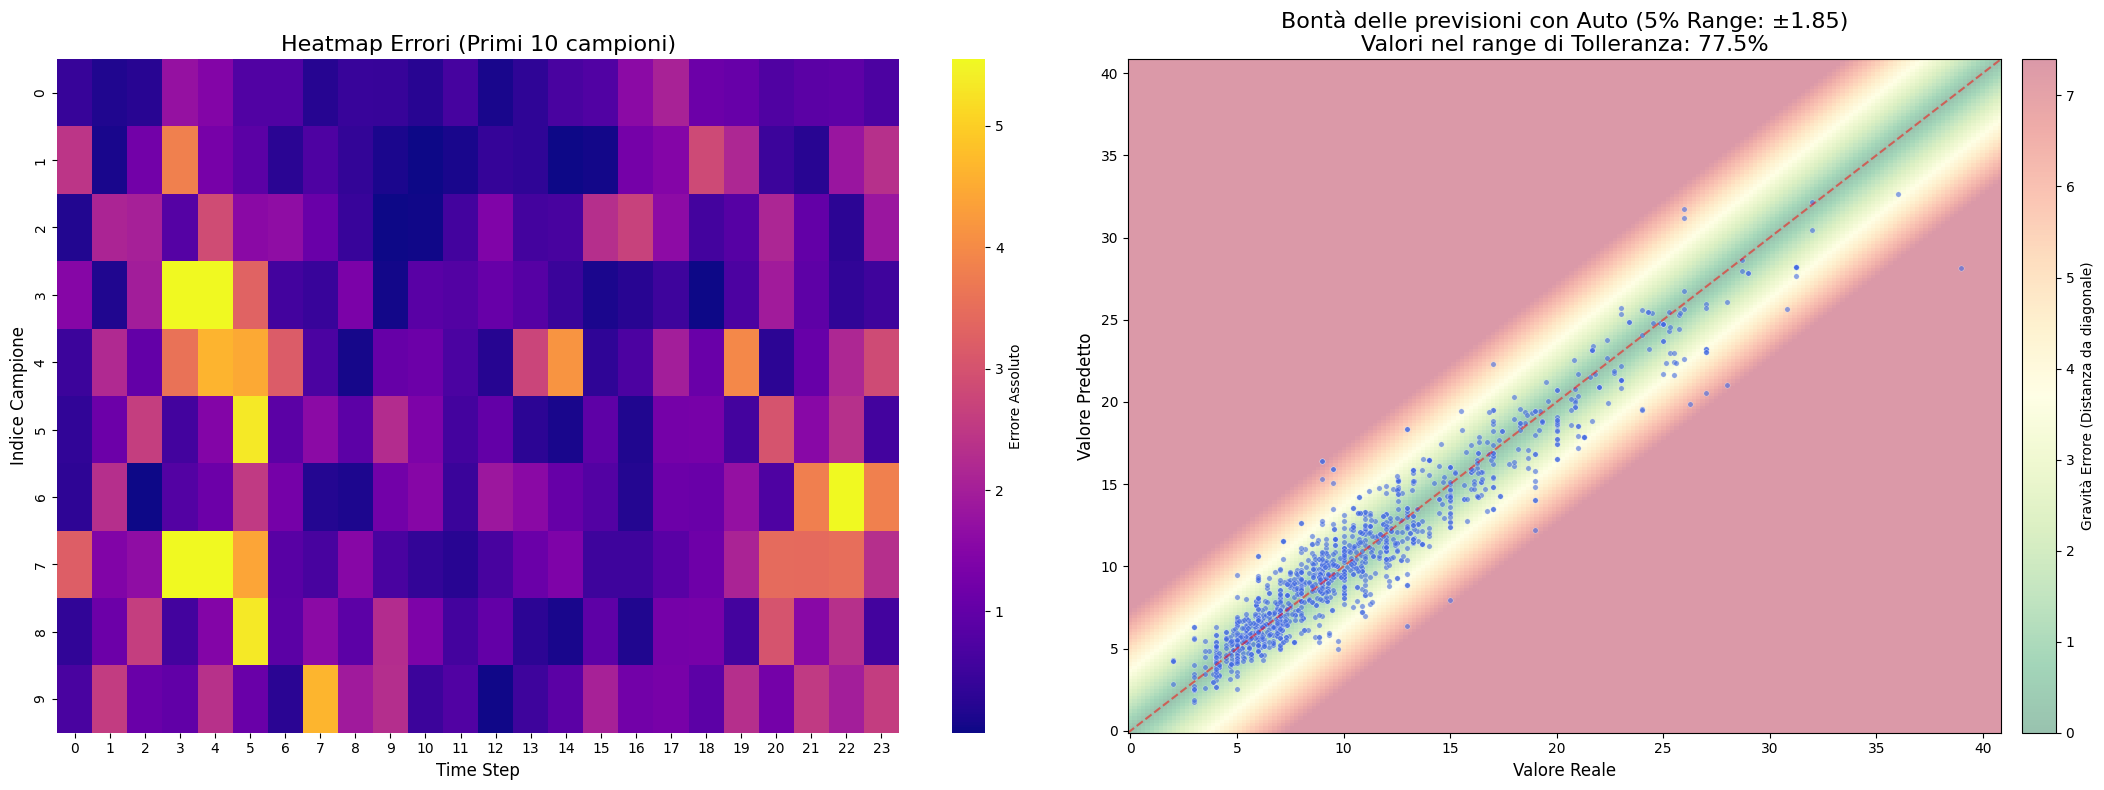

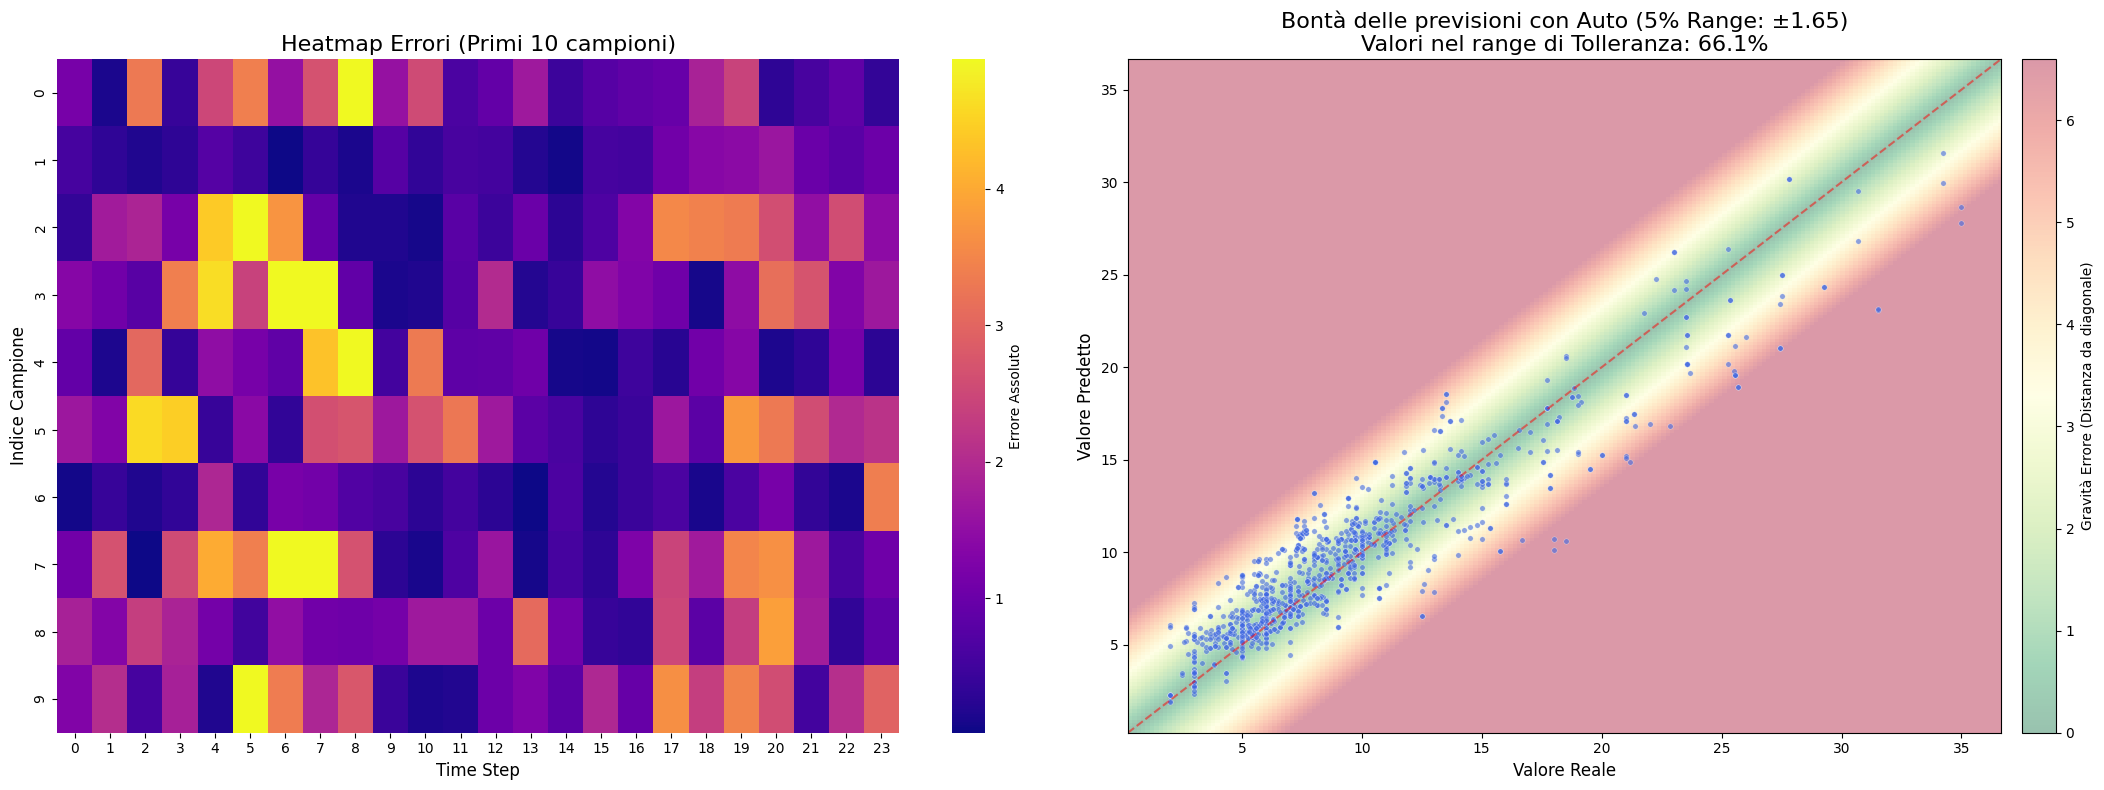

In [16]:
for key in splits.keys():
    X_sens, y_sens = splits[key]
    print(f"Sensore: {key}, X_test shape: {X_sens.shape if X_sens is not None else None}, y_test shape: {y_sens.shape if y_sens is not None else None}")

    y_pred = model.predict(scaler_X.transform(X_sens))
    plot_diagnosis_gradient(
          scaler_y.inverse_transform(y_pred),
          y_sens,
          save_path=f'pred_quality_sensor_{key}',
          max_samples_heatmap=10,
          scatter_sample_ratio=0.7
     )
    evaluate_and_log(
        y_sens,
        scaler_y.inverse_transform(y_pred),
        log_path=f"{exp_dir}/evaluation_log_sensor_{key}.json"
    )
    save_prediction_plots(
        y_sens,
        scaler_y.inverse_transform(y_pred),
        output_dir=f'{exp_dir}/TEST_sensor_{key}',
        prefix=f"pred_plot_sensor_{key}"
    )